In [1]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors
from qiskit.primitives import StatevectorSampler
from qiskit import transpile

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token='enter your ibm token')
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

In [3]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        
        qc.x(zero_inds)      # Line 1
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)    # Line 2
        qc.x(zero_inds)      # line 3
    return qc

In [51]:
def grover_search(marked_states, shots=100000, noise=None):
    oracle = grover_oracle(marked_states)
    grover_op = GroverOperator(oracle)

    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
    )
    
    qc = QuantumCircuit(grover_op.num_qubits)
    # Create even superposition of all basis states
    qc.h(range(grover_op.num_qubits))
    # qc.x(0)  #bug
    # Apply Grover operator the optimal number of times
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
    # Measure all qubits
    qc.measure_all()
    # qc.draw(output="mpl", style="iqp")

    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

    target = backend.target
    pm = generate_preset_pass_manager(target=target, optimization_level=3)

    circuit_isa = pm.run(qc)
    # circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

    sampler = AerSimulator(noise_model=noise)
    result = sampler.run(circuit_isa, shots=shots, memory=True).result()
    return result.get_counts()

In [52]:
def create_noise_model(f):
    noise_model = NoiseModel()

    # Add a bit-flip error on all single-qubit gates with a probability of 0.05
    bit_flip_error = errors.pauli_error([('X', f), ('I', 1-f)])
    noise_model.add_all_qubit_quantum_error(bit_flip_error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])

    # Add a phase-flip error on all single-qubit gates with a probability of 0.05
    phase_flip_error = errors.pauli_error([('Z', f), ('I', 1-f)])
    noise_model.add_all_qubit_quantum_error(phase_flip_error, ['u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])
    
    # Add a depolarizing error on two-qubit gates with a probability of 0.05
    depolarizing_error = errors.depolarizing_error(f, 2)
    noise_model.add_all_qubit_quantum_error(depolarizing_error, ['cx'])

    return noise_model

In [53]:
from math import log2
import numpy as np

def calculate_bias_entropy(output_map, marked_state):
    total_count = sum(output_map.values())

    bias = 0
    count = 0
    for key, val in output_map.items():
        if key not in marked_state:
            bias += val / total_count
        count += 1

    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return bias, entropy

In [54]:
def to_bin(number, num_bits):
    return format(number, f'0{num_bits}b')

In [55]:
def empty_dict(n):
    dict = {}
    keys = [to_bin(i,n) for i in range(pow(2,n))]
    dict = dict.fromkeys(keys, 0)
    return dict

bias is 0.21733
entropy is 2.0980852542536463


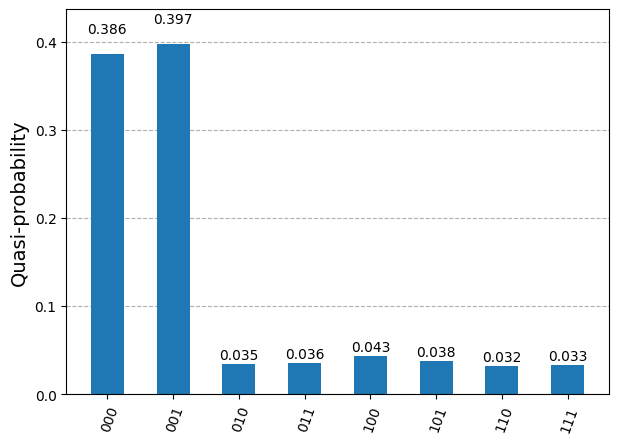

In [58]:
marked_states=['000', '001']
shots = 100000

noise = create_noise_model(0.001)
dist = empty_dict(len(marked_states[0]))
result = grover_search(marked_states, shots, noise=noise)
for key, val in result.items():
    dist[key] = val

bias, entropy = calculate_bias_entropy(dist, marked_states)

print(f"bias is {bias}")
print(f"entropy is {entropy}")

plot_distribution(dist)

# Entropy vs Noise

In [ ]:
marked_states=['000', '001']
shots = 100000

biases = []
entropies = []
noise_levels = [j/100.0 for j in range(0, 51)]
for i in noise_levels:
    noise = create_noise_model(i)
    result = grover_search(marked_states, shots, noise=noise)

    bias, entropy = calculate_bias_entropy(result, marked_states)
    biases.append(bias)
    entropies.append(entropy)
# print(f"bias: {arr[0]}, entropy: {arr[1]}")
# plot_histogram(results)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(noise_levels, entropies, marker='o')  # marker='o' adds points for each x-y pair
plt.xlabel('noise_level')
plt.ylabel('entropy')
plt.title('Plot of Entropy vs Noise')
plt.grid(True)
plt.show()